In [0]:
import pandas as pd
import numpy as np
import string
import csv
from scipy.sparse import coo_matrix
from scipy.spatial import distance
from scipy.sparse import find
import matplotlib.pyplot as plt
import time
import itertools
%matplotlib inline

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Global variables
k = 4
col_ind = 0   # global variable for finding binary matrix
num_docs = 0  # later changed to the number of documents when we load data
m = 120       # number of hash function
num_hash = m
given_stop_words=["i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself","yourselves","he","him","his",
"himself","she","her","hers","herself","it","its","itself","they","them","their","theirs","themselves","what","which","who",
"whom","this","that","these","those","am","is","are","was","were","be","been","being","have","has","had","having","do","does",
"did","doing","a","an","the","and","but","if","or","because","as","until","while","of","at","by","for","with","about","against",
"between","into","through","during","before","after","above","below","to","from","up","down","in","out","on","off","over","under",
"again","further","then","once","here","there","when","where","why","how","all","any","both","each","few","more","most","other",
"some","such","no","nor","not","only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"]
para_hash = 2000 # a & b of hash function

# NOTICE: a & b should be kept the same for question 6
func_hash = np.random.randint(0, para_hash, (num_hash, 2)) # a & b of hash function


In [0]:
# parameters for band hash
p = 982451653
b = 20
r = 6
m = 120

# NOTICE: a & b should keep the same for question 6
hash_a_val = np.random.randint(p, size=r)
hash_a_submat = np.tile(hash_a_val,b)
hash_a_submat = hash_a_submat.reshape(m,1)
hash_b_val = np.random.randint(p, size=r)
hash_b_submat = np.tile(hash_b_val,b)
hash_b_submat = hash_b_submat.reshape(m,1)

In [0]:
# Question 1
def data_loader(url):
  df_reviews=pd.read_json(url,orient='records',lines = True)
  df_reviews_orig=df_reviews
  df_reviews=df_reviews.drop(columns=['asin','reviewerName','helpful','overall','summary','unixReviewTime','reviewTime'])
  regex_dict=r'\b(?:{})\b'.format('|'.join(given_stop_words))
  df_reviews['reviewText'] = df_reviews['reviewText'].str.replace(regex_dict, '')
  df_reviews.reviewText = df_reviews.reviewText.apply(lambda x: x.lower())
  df_reviews.reviewText = df_reviews.reviewText.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
  df_reviews.reviewText=(df_reviews.reviewText).astype(str)
  df_reviews['reviewText']=df_reviews['reviewText'].str.split()
  df_reviews['reviewText']=df_reviews['reviewText'].str.join(" ")
  df_reviews = df_reviews[df_reviews['reviewText'].apply(lambda x: len(x) > k-1)]
  return df_reviews, df_reviews_orig

In [0]:
# Question 2
def cal_binary_matrix(review_text):
  g_rows=[]
  g_cols=[]
  char_mapping={'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10,'l':11,'m':12,'n':13,'o':14,'p':15,'q':16,'r':17,'s':18,'t':19,'u':20,'v':21,'w':22,'x':23,'y':24,'z':25,'0':26,'1':27,'2':28,'3':29,'4':30,'5':31,'6':32,'7':33,'8':34,'9':35,' ':36}
  def find_index_in_binary_matrix(review):
    global col_ind
    for i in range(len(review)-k+1):
      cur=review[i:i+k]
      # print(cur)
      ans=0
      index=k-1
      for c in cur:    
        ans+=(char_mapping[c])*(37**(index))
        
        index-=1
      g_rows.append(ans)
      g_cols.append(col_ind)
    col_ind+=1
    # return rows
  review_text.apply(find_index_in_binary_matrix)
  g_rows=np.array(g_rows)
  g_cols=np.array(g_cols)
  data=np.ones((len(g_rows)))
  binary_matrix = coo_matrix((data, (g_rows, g_cols)), shape=(37**4,len(df_reviews)))
  return binary_matrix

In [0]:
# Question 3
def jaccard(x,y):
  x = np.asarray(x, np.bool) 
  y = np.asarray(y, np.bool) 
  return 1 - np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum())

def plot_jaccard_distance(jaccard_distance, bins):
  plt.hist(jaccard_distance, bins)
  plt.title("Pairwise Jaccard distance histogram")
  plt.xlabel('Jaccard distance')
  plt.ylabel('Count')
  plt.show()

def cal_jaccard_distance_randomPairs(binary_matrix):
  ind = np.arange(num_docs)
  np.random.shuffle(ind)
  ind = ind[:142]
  binary_submatrix = binary_matrix.tocsr()[:,ind]
  binary_submatrix = binary_submatrix.toarray()
  binary_submatrix = binary_submatrix[~np.all(binary_submatrix == 0, axis=1)]

  jaccard_distance = np.zeros((71*143))
  jaccard_index = 0

  for i in range(141):
    for j in range(i+1,142):
      jaccard_distance[jaccard_index] = jaccard(binary_submatrix[:,i], binary_submatrix[:,j])
      jaccard_index += 1
  jaccard_distance = jaccard_distance[:10000]
  print("min jaccard dist:"+str(np.min(jaccard_distance)))
  print("avg jaccard dist:"+str(np.mean(jaccard_distance)))
  bins = np.linspace(0.8,1,21)
  plot_jaccard_distance(jaccard_distance, bins)
  

In [0]:
# Question 4
# Parameter Tuning
def hit_pro_without_band():
  s = np.arange(0,1,0.01)
  y = 1-(1-s)**m
  plt.plot(s,y)
  plt.show()
def hit_pro_with_band():
  factors=[]

  def find_factors(n):
    for i in range(1,n+1):
      if(n%i==0):
        factors.append(i)

  find_factors(m)
  for idx in range(0,len(factors)):
    r=factors[idx]
    b=factors[len(factors)-idx-1]
    s=np.arange(0,1,0.01)
    y=1-(1-s**r)**b
    
    plt.plot(s,y,label="r="+str(r)) 
    plt.legend(bbox_to_anchor=(1, 1))
  plt.axvline(0.8, linestyle='--')
  plt.show()

In [0]:
# Question 4
def find_hash(row_num,a,b):
  return ((row_num*a)+b)%(37**k)
#37**4-> not prime 

def cal_signature_matrix(binary_matrix):
  binary_matrix_nonzero = np.asarray(binary_matrix.nonzero())
  binary_matrix_nonzero = binary_matrix_nonzero.T
  binary_matrix_index = np.split(binary_matrix_nonzero[:, 0], np.cumsum(np.unique(binary_matrix_nonzero[:, 1], return_counts=True)[1])[:-1])
  binary_matrix_index = np.asarray(binary_matrix_index)
  signature_mat = np.full((num_hash,binary_matrix_index.shape[0]),37**k) 
  # start = time.time()
  for index in range(binary_matrix_index.shape[0]):
    for i in range(num_hash):
        # print("k = "+str(k)+ "i= "+str(i)+ "j= "+str(j))
        signature_mat[i,index] = np.min(find_hash(binary_matrix_index[index],func_hash[i,0],func_hash[i,1]))
  # print(time.time() - start)
  return signature_mat
  
def cal_hash_signature_matrix(signature_mat):
  hash_a_mat = np.repeat(hash_a_submat, num_docs, axis=1)
  hash_b_mat = np.repeat(hash_b_submat, num_docs, axis=1)
  tmp_hash_mat = ((hash_a_mat*signature_mat)+hash_b_mat)%p
  hash_signature_mat = np.zeros((b,num_docs))
  i = 0
  for row in range(0, m, r):
    hash_signature_mat[i] = np.sum(tmp_hash_mat[row:row+r,:] ,axis=0)
    i += 1
  return hash_signature_mat

In [0]:
def make_pairs():
  # start=time.time()
  bucket_list=list()
  for b in range(hash_signature_mat.shape[0]):
    list_temp = ([(np.where(hash_signature_mat[b]==this)[0]).tolist() for this in np.unique(hash_signature_mat[b])])
    for l in list_temp:
      if(len(l)>=2):
        bucket_list.extend(list(itertools.combinations(l, 2)))

  unique_pairs = bucket_list
  unique_pairs.sort()
  unique_pairs = list(unique_pairs for unique_pairs,_ in itertools.groupby(unique_pairs))
  print("len of unique pairs:"+str(len(unique_pairs)))
  return unique_pairs
  # print(time.time()-start)

In [0]:
def make_row_index_dict():
  bin_mat = binary_matrix.tocsc()
  [row, col, vals]=find(bin_mat)
  unq=np.unique(col,return_counts=True)
  bin_mat_dict={}
  sk=0
  for dc in range(num_docs):
    bin_mat_dict[dc]=(row[sk:sk+ unq[1][dc]]).tolist()
    sk=sk+unq[1][dc]
  return bin_mat_dict

In [0]:
def findJaccardDistance(doc1Idx, doc2Idx):
  doc1=set(bin_mat_dict[doc1Idx])
  doc2=set(bin_mat_dict[doc2Idx])
  unn=len(doc1.union(doc2))
  intn=len(doc1.intersection(doc2))
  return (1-(intn/unn))

In [0]:
def jaccardMapFunc(selected_pair):
  if(findJaccardDistance(selected_pair[0],selected_pair[1])<0.2):
    return True
  else:
    return False

In [0]:
def filterPairs():
  ans=map(jaccardMapFunc,unique_pairs)
  list_ans=np.array(list(ans))
  unique_pairs_np=np.array(unique_pairs)
  final_pairs = unique_pairs_np[list_ans]
  return final_pairs

In [0]:
def writeToFile():
  with open('similarReviews.csv','w') as opFile:
    writerObj = csv.writer(opFile, delimiter =',')
    writerObj.writerow(["reviewerID_1","reviewerID_2","reviewText_1","reviewText_2"])
    for pair_p in final_pairs:
      writerObj.writerow([df_reviews_orig.iloc[pair_p[0]].reviewerID, df_reviews_orig.iloc[pair_p[1]].reviewerID, df_reviews_orig.iloc[pair_p[0]].reviewText, df_reviews_orig.iloc[pair_p[1]].reviewText])


In [0]:
# Question 6
def find_new_binary_matrix(review):
  binary_mat = np.zeros((37**k))
  char_mapping={'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10,'l':11,'m':12,'n':13,'o':14,'p':15,'q':16,'r':17,'s':18,'t':19,'u':20,'v':21,'w':22,'x':23,'y':24,'z':25,'0':26,'1':27,'2':28,'3':29,'4':30,'5':31,'6':32,'7':33,'8':34,'9':35,' ':36}
  for i in range(len(review)-k+1):
    cur=review[i:i+k]
    # print(cur)
    ans=0
    index=k-1
    for c in cur:    
      ans+=(char_mapping[c])*(37**(index))
      index-=1
    binary_mat[ans] = 1
  return binary_mat

def newReview_writeToFile(min_jaccard_distance_index):
  print(min_jaccard_distance_index)
  with open('NearestNeighbor.csv','w') as opFile:
    writerObj = csv.writer(opFile, delimiter =',')
    writerObj.writerow(["reviewerID", "reviewText"])
    for reviewIdx in range(min_jaccard_distance_index.shape[0]):
      writerObj.writerow([df_reviews.iloc[min_jaccard_distance_index[reviewIdx]].reviewerID, df_reviews.iloc[min_jaccard_distance_index[reviewIdx]].reviewText])


def cal_newReview_jaccard_distance(new_review_bucket,new_review_binary_mat):
  new_review_binary_submatrix = (binary_matrix.tocsr()[:,new_review_bucket]).toarray()
  new_review_binary_mat = new_review_binary_mat.reshape(37**4,1)
  new_review_binary_submatrix = np.concatenate((new_review_binary_mat, new_review_binary_submatrix), axis=1)
  new_review_binary_submatrix = new_review_binary_submatrix[~np.all(new_review_binary_submatrix == 0, axis=1)]
  jaccard_distance = np.zeros((new_review_bucket.shape))

  for i in range(1,new_review_bucket.shape[0],1):
    jaccard_distance[i-1] = jaccard(new_review_binary_submatrix[:,0], new_review_binary_submatrix[:,i])

  min_jaccard_distance = np.min(jaccard_distance)
  min_index = np.where(jaccard_distance==min_jaccard_distance)
  return new_review_bucket[min_index], min_jaccard_distance

def findNearestNeighbor(new_review):
  # Data Processing
  new_review = new_review.lower()
  new_review = new_review.translate(str.maketrans('','',string.punctuation))
  new_review = ' '.join([word for word in new_review.split() if word not in given_stop_words])
  new_review = ' '.join(new_review.split())
  new_review_binary_mat = find_new_binary_matrix(new_review)
  new_review_indexOfOne = np.where(new_review_binary_mat==1)[0]
  new_review_indexOfOne = np.asarray(new_review_indexOfOne)
  new_review_hash = np.zeros((num_hash))
  for i in range(num_hash):
    new_review_hash[i] = np.min(find_hash(new_review_indexOfOne,func_hash[i,0],func_hash[i,1]))
  new_review_tmp_mat = ((hash_a_submat[:,0]*new_review_hash)+hash_b_submat[:,0])%p
  new_review_signature_mat = np.zeros((b))
  i = 0;

  for row in range(0, m, r):
    new_review_signature_mat[i] = np.sum(new_review_tmp_mat[row:row+r] ,axis=0)
    i += 1
  new_review_bucket = []
  for band_index in range(b):
    target = new_review_signature_mat[band_index]
    # print(np.where(hash_signature_mat[band_index,:]==target)[0])
    new_review_bucket.append(np.where(hash_signature_mat[band_index,:]==target)[0])
  new_review_bucket = np.asarray(new_review_bucket)
  new_review_bucket = np.unique(new_review_bucket)
  min_jaccard_distance_index, min_jaccard_distance = cal_newReview_jaccard_distance(new_review_bucket,new_review_binary_mat)
  newReview_writeToFile(min_jaccard_distance_index)
  return min_jaccard_distance_index, min_jaccard_distance

min jaccard dist:0.8611898016997167
avg jaccard dist:0.968993899295833


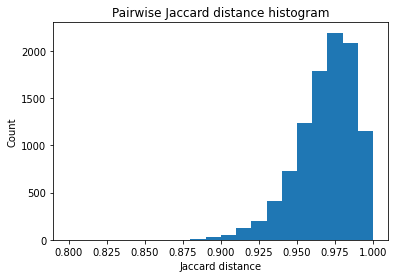

len of unique pairs:10282


In [34]:
url = '/content/drive/My Drive/amazonReviews.json'
df_reviews,df_reviews_orig = data_loader(url)
num_docs=len(df_reviews)
binary_matrix = cal_binary_matrix(df_reviews.reviewText)
cal_jaccard_distance_randomPairs(binary_matrix)
signature_mat = cal_signature_matrix(binary_matrix)
hash_signature_mat = cal_hash_signature_matrix(signature_mat)
unique_pairs= make_pairs()
bin_mat_dict=make_row_index_dict()
final_pairs=filterPairs()
writeToFile()
# new_review = '     i .     me , ,     great!   so:   |'
# min_jaccard_distance_index, min_jaccard_distance = findNearestNeighbor(new_review)

In [35]:
print(binary_matrix)

  (455083, 0)	1.0
  (1844800, 0)	1.0
  (787806, 0)	1.0
  (1036414, 0)	1.0
  (864098, 0)	1.0
  (110907, 0)	1.0
  (355241, 0)	1.0
  (24793, 0)	1.0
  (917377, 0)	1.0
  (208070, 0)	1.0
  (201963, 0)	1.0
  (1850156, 0)	1.0
  (985987, 0)	1.0
  (872474, 0)	1.0
  (420807, 0)	1.0
  (576595, 0)	1.0
  (718280, 0)	1.0
  (338113, 0)	1.0
  (1265229, 0)	1.0
  (1833624, 0)	1.0
  (374300, 0)	1.0
  (729986, 0)	1.0
  (771234, 0)	1.0
  (423279, 0)	1.0
  (668054, 0)	1.0
  :	:
  (1830986, 157679)	1.0
  (276690, 157679)	1.0
  (866761, 157679)	1.0
  (209422, 157679)	1.0
  (251977, 157679)	1.0
  (1826505, 157679)	1.0
  (110906, 157679)	1.0
  (355206, 157679)	1.0
  (23499, 157679)	1.0
  (869499, 157679)	1.0
  (310743, 157679)	1.0
  (252529, 157679)	1.0
  (1846950, 157679)	1.0
  (867362, 157679)	1.0
  (231661, 157679)	1.0
  (1074835, 157679)	1.0
  (411550, 157679)	1.0
  (234077, 157679)	1.0
  (1164225, 157679)	1.0
  (1844800, 157679)	1.0
  (787819, 157679)	1.0
  (1036902, 157679)	1.0
  (882172, 157679)	1.0
  (77